# Explainable AI (XAI)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
#to find the best set of parameter setting, we can run a grid search
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import random
import numpy as np

from sklearn import tree
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import wittgenstein as lw
import keras_tuner
import keras
from keras_tuner import HyperParameters
import tensorflow as tf

import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from statistics import mean, stdev
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import classification_report, f1_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.stats import loguniform as sp_loguniform
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
import shap

2024-12-16 12:32:34.839541: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 12:32:34.867227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734348754.892111   67092 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734348754.901039   67092 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 12:32:34.931175: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
RANDOM_STATE = 42
dev_set = pd.read_csv('../data/ml_datasets/undersampling/dev_set.csv').sample(frac = 1, random_state=RANDOM_STATE) # shuffling the data so not to introduce bias
test_set = pd.read_csv('../data/ml_datasets/undersampling/test_set.csv')

In [3]:
dev_set['race_season%autumn'] = dev_set['race_season%autumn'].astype(int)
dev_set['race_season%spring'] = dev_set['race_season%spring'].astype(int)
dev_set['race_season%summer'] = dev_set['race_season%summer'].astype(int)
dev_set['race_season%winter'] = dev_set['race_season%winter'].astype(int)

test_set['race_season%autumn'] = test_set['race_season%autumn'].astype(int)
test_set['race_season%spring'] = test_set['race_season%spring'].astype(int)
test_set['race_season%summer'] = test_set['race_season%summer'].astype(int)
test_set['race_season%winter'] = test_set['race_season%winter'].astype(int)

In [4]:
dev_label = dev_set.pop('label')
test_label = test_set.pop('label')

In [5]:
RUS = RandomUnderSampler(random_state=RANDOM_STATE)

param_dist = {"classifier__max_depth": [3, 5, 10, 15, 20, None],
              "classifier__max_features": sp_randint(3, len(dev_set.iloc[0]) + 1),
              "classifier__min_samples_split": [20, 30, 50, 100],
              "classifier__min_samples_leaf": [10, 20, 30, 50, 100],
              "classifier__criterion": ["entropy", "gini"],
              "classifier__class_weight":['balanced', None, {0: 0.8, 1: 0.2}, {0: 0.6, 1: 0.4}]} # class weights are related to over/undersampling chosen
#define the number of iters
n_iter_search = 100 # Total-Iteration: 400
#define the model
clf = tree.DecisionTreeClassifier()

pipeline = ImbPipeline([
    ('undersampler', RUS),  # Passo di undersampling
    ('classifier', clf)  # Il classificatore
], verbose=False)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

#define the grid search
rand_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=4, 
                            scoring='f1_weighted',
                            refit=False,
                            cv=skf)
#run the grid search
rand_search.fit(dev_set, dev_label);
print(rand_search.best_params_)

{'classifier__class_weight': {0: 0.8, 1: 0.2}, 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 13, 'classifier__min_samples_leaf': 30, 'classifier__min_samples_split': 50}


In [6]:
model = tree.DecisionTreeClassifier(class_weight={0: 0.8, 1: 0.2}, criterion='gini', max_depth=10, max_features=13, min_samples_leaf=30, min_samples_split=50)

dev_set_u, dev_label_u = RUS.fit_resample(dev_set, dev_label)
model.fit(dev_set_u, dev_label_u)

train_labels_model = model.predict(dev_set_u)

test_labels_model = model.predict(test_set)
validation = classification_report(test_label, test_labels_model, output_dict=True)
validation

{'0': {'precision': 0.8913277532733651,
  'recall': 0.9399011170115363,
  'f1-score': 0.91497023066776,
  'support': 27305.0},
 '1': {'precision': 0.3546991742036964,
  'recall': 0.22376581493425948,
  'f1-score': 0.27441435959841803,
  'support': 4031.0},
 'accuracy': 0.8477789124329844,
 'macro avg': {'precision': 0.6230134637385307,
  'recall': 0.5818334659728979,
  'f1-score': 0.594692295133089,
  'support': 31336.0},
 'weighted avg': {'precision': 0.8222969324209961,
  'recall': 0.8477789124329844,
  'f1-score': 0.832570412047626,
  'support': 31336.0}}

In [7]:
perturbation_data = dev_set_u
perturbation_labels = dev_label_u
perturbation_predictions = train_labels_model

explanation_data = test_set
explanation_labels = test_label
explanation_predictions = test_labels_model

explanations = dict()

In [8]:
interventional_explanation_algorithm = shap.TreeExplainer(
    model=model,
    data=dev_set_u,                       # perturb on a causal model induced on perturbation data
    feature_perturbation="interventional"  # use a causal model
)

distributional_explanation_algorithm = shap.TreeExplainer(
    model=model,
    feature_perturbation="tree_path_dependent"  # condition on the distribution learned on the train data
)

In [9]:
interventional_explanations = interventional_explanation_algorithm(explanation_data)
distributional_explanations = distributional_explanation_algorithm(explanation_data)

explanations["shap_interventional"] = interventional_explanations.values
explanations["shap_distributional"] = distributional_explanations.values

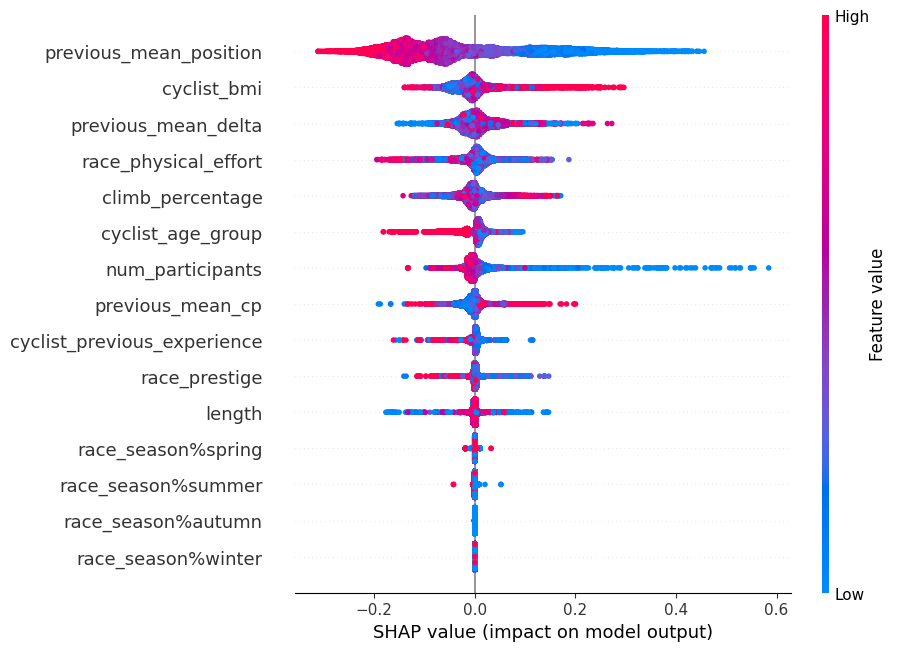

In [10]:
shap.plots.beeswarm(interventional_explanations[:, :, 1], max_display=20)

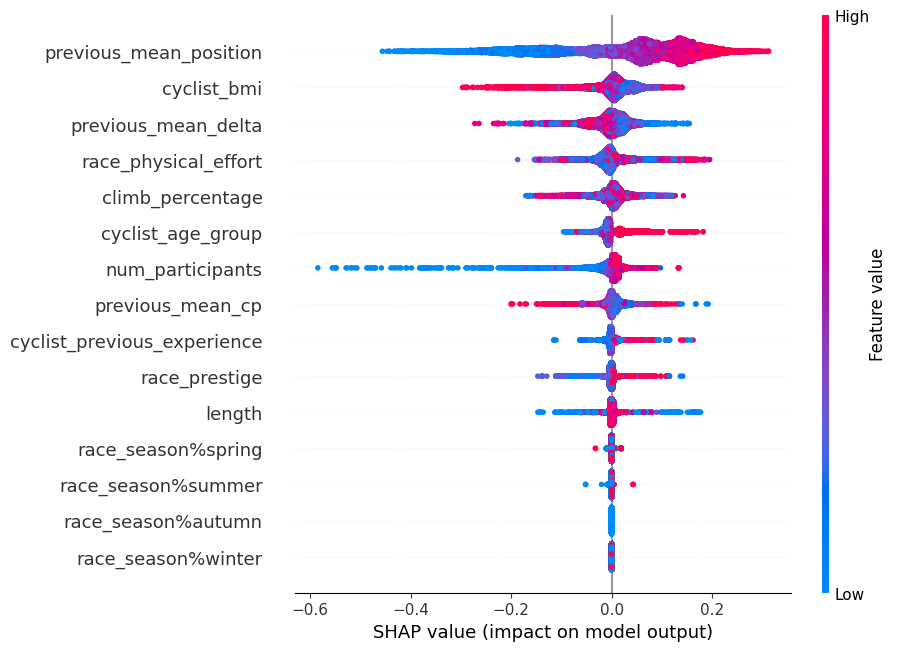

In [11]:
shap.plots.beeswarm(interventional_explanations[:, :, 0], max_display=20)

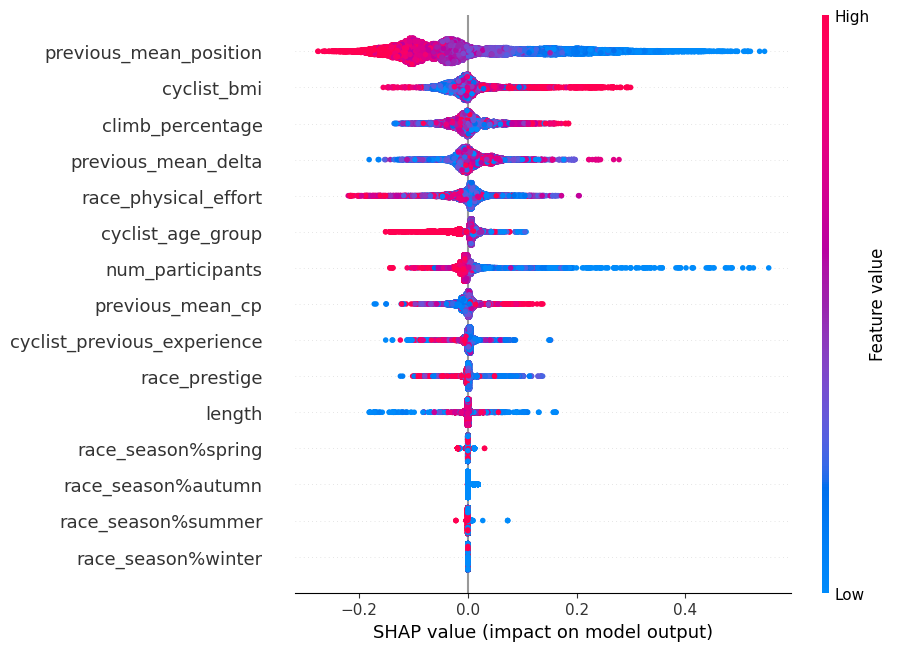

In [12]:
shap.plots.beeswarm(distributional_explanations[:, :, 1], max_display=20)

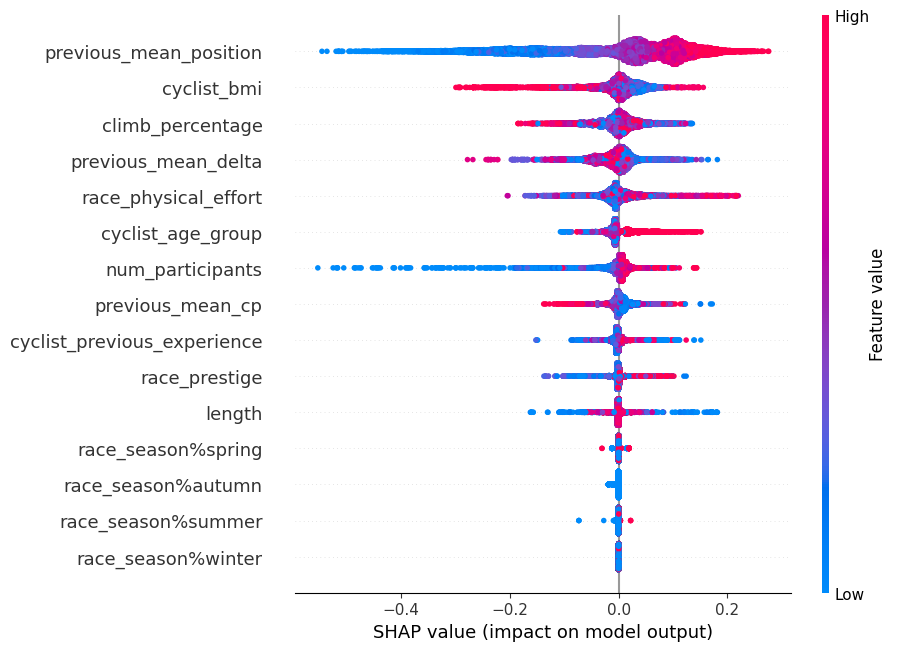

In [13]:
shap.plots.beeswarm(distributional_explanations[:, :, 0], max_display=20)